<a href="https://colab.research.google.com/github/jx-dohwan/-Deep_Learning_from_Scratch_2_study/blob/main/CH4_Word2vec%EC%86%8D%EB%8F%84%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH4_Word2vec속도개선
- Embedding이라는 새로운 계층을 도입
- 네거티브 샘플링이라는 새로운 손실 함수를 도입

## 1. word2vec개선

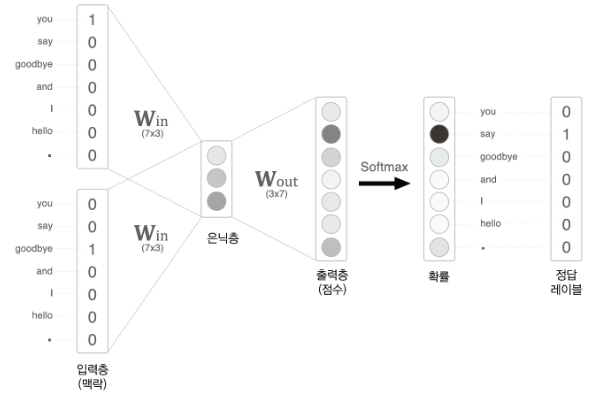

> 위의 모델은 작은 데이터에서는 문제가 없다. 하지만 거대한 말뭉치를 다루게 되면 몇 가지 문제가 발생한다. 입력층과 출력층에는 각 100만 개의 뉴런이 존재한다면 이 수 많은 뉴런 때문에 중간 계산에 많은 시간이 소요된다. 정확히는 다음의 두 계산이 병목이 된다.
- 입력층의 원핫 표현과 가중치 행렬 Win의 곱을 계산이 병
- 은닉층과 가중치 행렬 Wout의 곱 및 Softmax 계층의 계산

> 첫번째는 입력층의 원핫 표현과 관련된 문제이다. 단어를 원핫 표현으로 다루기 때문에 어휘 수가 많아지면 원핫 표현의 벡터 크기도 커지는 것이다. 예를 들어 100만 개라면 그 원핫 표현 하나만 해도 원소 수가 100만 개인 벡터가 된다. 그러면 상당한 메모리를 차지하게 된다. 게다가 이 원핫 벡터와 가중치 행렬 Win을 곱해야 하는데, 이것만으로 계산 자원을 상당히 사용하게 된다. 그래서 이번 절에서 제시한 것이 Embedding 계층을 도입하는 것이다. <br><br> 두번째 문제는 은닉층 이후의 계산이다. 우선 은닉층과 가중치 행렬 Wout의 곱만 해도 계산량이 상당하다. 그리고 Softmax 계층에서도 다루는 어휘가 많아짐에 따라 계산량이 증가하는 문제가 있다. 이 문제는 네거티브 샘플링이라는 새로운 손실함수를 도입해서 해결할 수 있다.



### 1) Embedding 계층
> 앞 장의 word2vec 구현에서는 단어를 원핫 표현으로 바꿨다. 그리고 그것을 MatMul 계층에 입력하고, MatMul 계층에서 가중치 행렬을 곱했다. 그럼 여기서 어휘 수가 100만개인 경우를 상상해보자. 이때 은닉층 뉴런이 100개라면 MatMul 계층의 행렬 곱처럼 된다. 

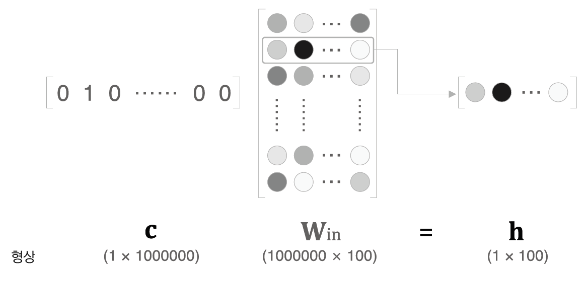

>100만개의 어휘를 담은 말뭉치가 있다면, 단어의 원핫 표현도 100만 차원이 된다. 그리고 이런 거대한 벡터와 가중치 행렬을 곱해야하는 것이다. 그러나 결과적으로 수행하는 일은 단지 행렬의 특정 행을 추출하는 것뿐이다. 따라서 원핫 표현으로의 변환과 MatMul 계층의 행렬 곱 계산은 사실 필요가 없는 것이다. <br><br> 그러면 가중치 매개변수로부터 단어 ID에 해당하는 행(벡터)를 추출하는 계층을 만들어 보자 그 계층을 Embedding 계층이라고 부른다. 참고로 Embedding이란 단어 임베딩(word embedding)에서 유래했다. 즉, Embedding 계층에 단어 임베딩(분산 표현)을 저장하는 것이다 .

### 2) Embedding 계층 구현
> 행렬에서 특정 행을 추출하기란 아주 쉽다. 예컨대 가중치 W가 2차원 넘파이 배열일 때, 이 가중치로부터 특정 행을 추출하려면 그저 W[2]나 W[5]처럼 원하는 행을 명시하면 끝이다.

In [1]:
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [5]:
# forward() 메서드를 구현해보자 
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None # idx에는 추출하는 행의 인덱스를 배열로 저장한다. 

  def forward(self, idx):
    W, = self.params 
    self.idx = idx
    out = W[idx]
    return out 

> Embedding 계층의 순전파는 가중치 W의 특정 행을 추출할 뿐이었다. 단순히 가중치의 특정 행 뉴런만(아무것도 손대지 않고)다음 층으로 흘려보낸 것이다.

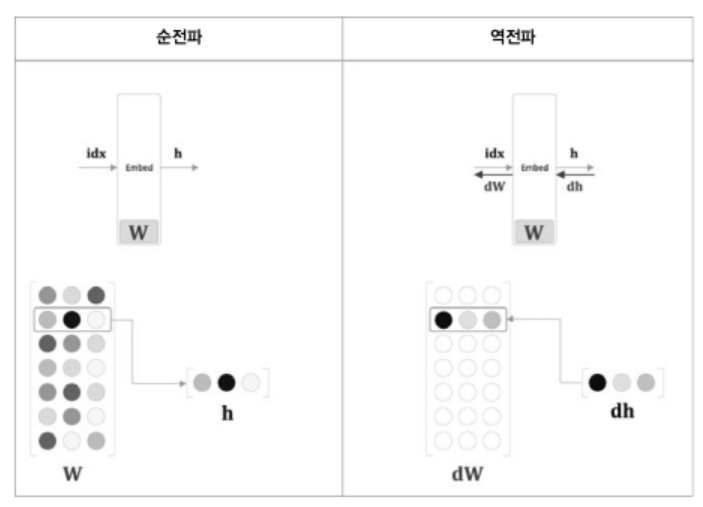

In [6]:
def backward(self, dout):
  dW = self.grads 
  dW[...] = 0
  dW[self.idx] = dout
  return None 

> 역전파에서는 앞 층(출력 측 층)으로부터 전해진 기울기를 다음 층으로 그대로 흘려주면 된다. 다만, 앞 층으로부터 전해진 기울기를 가중치 기울기 dW의 특정 행에 설정한다. <br><br> 이 코드는 가중치 기울기 dW를 꺼낸 다음 dW[...] = 0 문장에서 dW의 원소를 0으로 덮어쓴다(dw 자체를 0으로 설정하는 게 아니라. dW의 형상을 유지한 채, 그 원소들을 0으로 덮어쓰는 것이다.) 그리고 앞 층에서 전해진 기울기 dout을 idx번재 행에 할당한다.

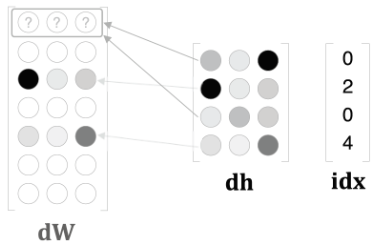

- 문제는 앞의 backward()를 구현하는 데는 사실 문제가 하나 더 있다. 그 문제는 idx의 원소가 중복될 때 발생한다. 
- 위의 그림과 같이 dh의 각 행 값을 idx가 가리키는 장소에 할당해보겠다. 
- 그러면 dW의 0번째 행에 2개의 값이 할당된다. 먼저 쓰여진 값을 덮어쓴다는 뜻이다. 
- 이 중복 문제를 해결하려면 '할당'이 아닌 '더하기'를 해야한다.
- 즉, dh의 각 행의 값을 dW의 해당 행에 더해준다.

> 그러면 이제 역전파를 다시 올바르게 구현해보자

In [7]:
def backward(self, dout):
  dW, = self.grads
  dW[...] = 0

  for i, word_id in enumerate(self.idx):
    dW[word_id] += dout[i]
    # 혹은
    # np.add.at(dW, self.idx, dout)

    return None 

- 여기에서 for문을 사용해 해당 인덱스에 기울기를 더했다. 이것으로 idx에 중복 인덱스가 있더라도 올바르게 처리된다.
- 참고로, for문 대신 넘파이 np.add.at()을 사용해도 된다 
  - np.add.at(A, idx, B)는 B를 A의 idx번재 행에 더해준다.

> 일반적으로 파이썬에서 for문보다 넘파이의 내장 메서드를 사용하는 편이 더 빠르다. 넘파이의 메서드에는 속도와 효율을 높여주는 최적화가 적용돼 있기 때문이다. 따라서 앞의 소스 코드도 for문 대신 np.add.at()을 사용하도록 수정하면 효율이 훨씬 좋아진다. 

> 지금까지 MatMul 계층을 Embedding 계층으로 전환했다. 그 효과로 메모리 사용량을 줄이고 쓸데없는 계산도 생략할 수 있게 되었다. 

## 2.word2vec
> 남은 병목 현상은 은닉층 이휴의 처리이다. 이 병목 현상을 해소하는게 이번절의 목표이다. 이를 위해서 네거티브(부정적) 샘플링이라는 기법을 사용할 것이다.  Softmax대신 네거티브 샘플링을 이용하면 어휘가 아무리 많아져도 계산량을 낮은 수준에서 일정하게 억제할 수 있다.

### 1) 은닉층 이후 계산의 문제점
> 어휘가 많아지면 Softmax의 계산량도 증가한다. Softmax를 대신할 가벼운 계산이 절실하다.

### 2) 다중 분류에서 이진 분류로
> 다중 분류(혹은 다중 클래스 분류)를 '이진 분류'로 근사하는 것이 네거티브 샘플링을 이해하는데 중요한 포인트이다. 즉 Yes/No로 답할 수 있는 질문을 생각해내야 한다. 예를 들면 맥락이 you와 goodbye일때 타깃 단어 say입니까? 라는 질문에 답하는 신경망을 생각해내야 한다.

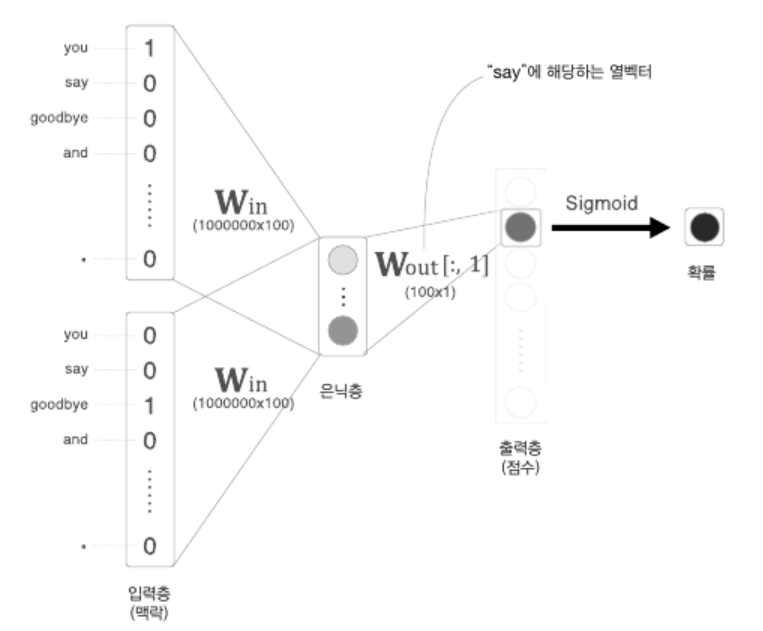

- 그림에서 보듯 출력층의 뉴런은 하나뿐이다.
- 따라서 은닉층과 출력 측의 가중치 행렬의 내적 'say'에 해당하는 열만 추출하고
- 그 추출된 벡터와 은닉층 뉴런과의 내적을 계간하면 끝이다. 

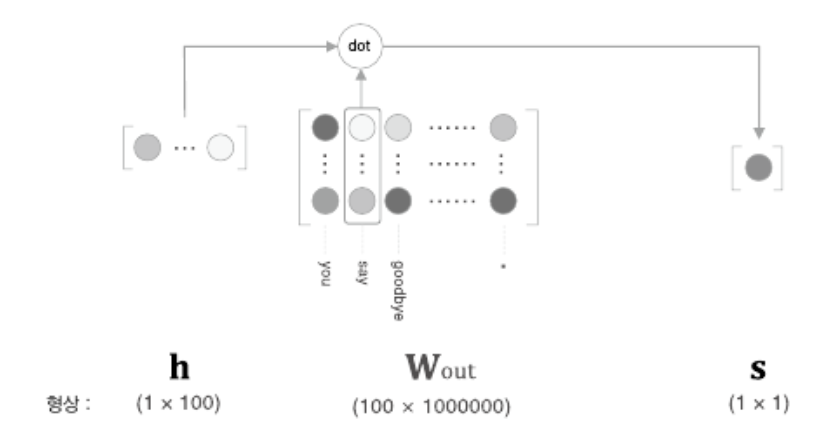

- 출력 측의 가중치 Wout에서는 각 단어 ID의 단어 벡터가 각각의 열로 저장되어 있다.
- 이 예에서는 'say'에 해당하는 단어 벡터를 추출한다.
- 그리고 그 벡터와 은닉층 뉴런과의 내적을 구한다. 이렇게 구한 값이 최종 점수인 것이다.

### 3) 시그모이드 함수와 교차 엔트로피 오차
> 이진 분류 문제를 신경망으로 풀려면 점수에 시그모이드 함수를 적용해 확률로 변환하고, 손실을 구할 때는 손실 함수로 교차 엔트로피 오차를 사용한다. 이 둘은 이진 분류 신경망에서 가장 흔하게 사용되는 조합이다. 

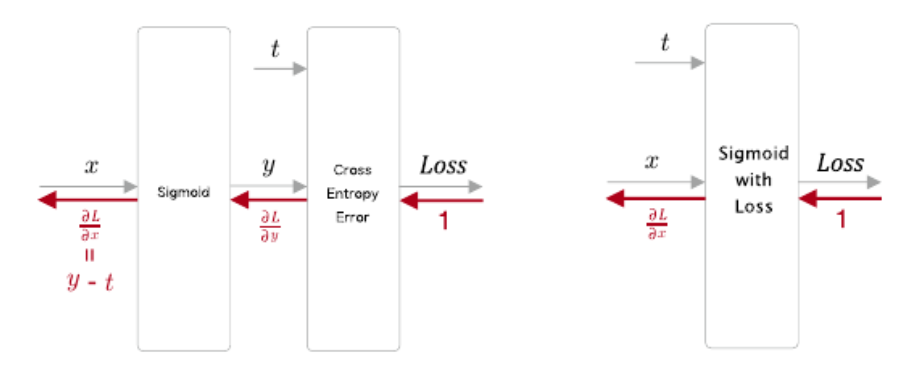

### 4) 다중 분류에서 이진 분류로(구현)
> Embedding Dot 계층을 도입한다. 이 계층은 Embedding 계층과 dot 연산(내적)의 처리를 합친 계층이다. 은닉층 뉴런 h는 Embedding Dot 계층을 거쳐 Sigmoid with Loss 계층을 통과합니다. 바다시피 Embedding Dot 계층을 사용하면서 은닉층 이후의 처리가 간단해 졌다.

In [8]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
from common.np import *  # import numpy as np
from common.layers import Embedding, SigmoidWithLoss
import collections

In [9]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### 5) 네거티브 샘플링
> 긍정적에 대해서는 Sigmoid계층의 출력을 1에 가깝게 만들고, 부정적 예에 대해서는 Sigmoid 계층의 출력을 0에 가깝게 만드는 것이다.<br><br> 네거티브 샘플링 기법은 긍정적 예를 타깃으로 한 경우의 손실을 구한다. 그와 동시에 부정적 예를 몇 개 샘플링하여, 그 부정적 예에 대해서도 마찬가지로 손실을 구한다. 그리고 각각의 데이터의 손실을 더한 값을 최종 손실로 한다.

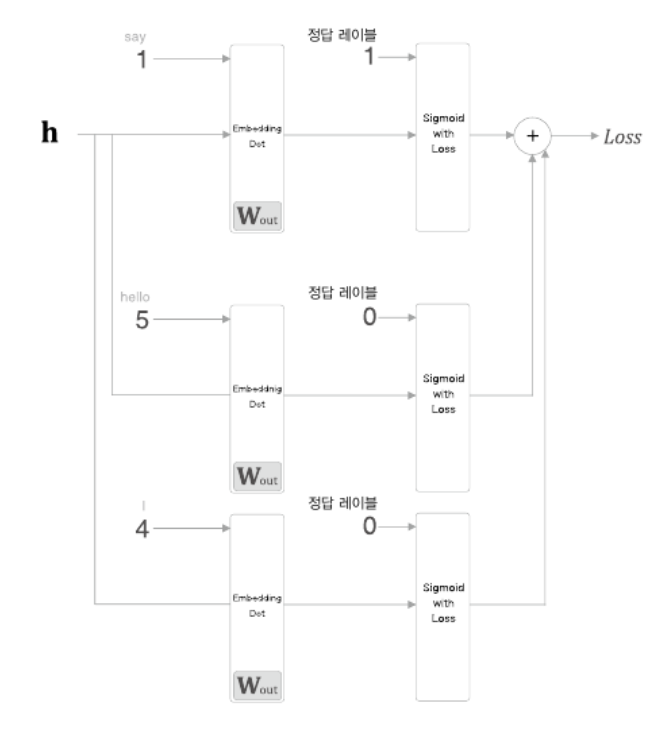

### 6) 네거티브 샘플링의 샘플링 기법

> 부정적 예를 어떻게 샘플링 하느냐가 문제인데 다행히 단순이 무작위로 샘플링하는 것 보다 좋은 방법이 있다. 바로 말뭉치의 통계 데이터를 기초로 샘플링 하는 방법이다. 구체적으로 말하면, 말뭉치에서 자주 등장하는 단어를 많이 추출하고 드물게 등장하는 단어를 적게 추출하는 것이다. <br><br> 말뭉치에서의 단어 빈도를 기준을 샘플링하려면, 먼저 말뭉치에서 각 단어의 출현 횟수를 구해 '확률분포'로 나낸다.그런 다음 그 확률분포대로 단어를 샘플링하면 된다. 확률 분포대로 샘플링 하므로 말뭉치에 자주 등장하는 단어는 선택될 가능성이 높다. 같은 이유로 희소한 단어는 선택되기 어렵다.

In [10]:
import numpy as np

np.random.choice(10)


4

In [11]:
np.random.choice(10)

0

In [12]:
words = ['you', 'say' ,'goodbye', 'I', 'hello', '.']
np.random.choice(words)

'hello'

In [13]:
np.random.choice(words, size=5)

array(['goodbye', 'I', 'you', 'you', '.'], dtype='<U7')

In [14]:
np.random.choice(words, size=5, replace=False)

array(['I', 'goodbye', 'you', 'say', 'hello'], dtype='<U7')

In [15]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

'you'

In [16]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p,0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.64196878 0.33150408 0.02652714]


In [17]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [18]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[0 2]
 [4 2]
 [1 3]]


In [19]:
class NegativeSamplingLoss:
  def __init__(self, W, corpus, power=0.75, sample_size=5): # w:출력측 가중치, corpus:말뭉치를 뜻함, power:확률분포에 제곱할 값, sample_size:부정적 예의 샘플링 횟수
    self.sample_size = sample_size
    self.sampler = UnigramSampler(corpus, power, sample_size) # 이 클래스를 생성하여 인스턴스 변수인 sampler로 저장, 또한 부정적 예의 심플링 횟수는 인스턴스 변수인 sample_size에 저장
    # loss_layers[0]과 embeded_dot_layers[0]이 긍정적인 계층
    # 그런 다음이 예층에서 사용하는 매개변수와 기울기를 각각 배열로 저장
    # 부정적 예를 다루는 계층이 sample_size개 만큼이기 때문에 긍정적 예를 다루는 계층은 sample_size+1을 한다. 여기서는 긍정적 계층이 필요하기 때문이다.
    self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
    self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
    self.params, self.grads = [], []
    for layer in self.embed_dot_layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, h, target):
    batch_size = target.shape[0]
    negative_sample = self.sampler.get_negativ_sample(target) # 부정적 예를 샘플링하여 저장

    # Embedding Dot 계층의 forward점수를 구하고 이어서 이 점수와 레이블을 Sigmoid with Loss 계층으로 흘려 손실을 구한다.
    # 여기에서 긍정적 예의 정답 레이블은 1이고 부정적 예의 정답 레이블은 0임에 주의하라
    # 긍정적 예 순전파
    score = self.embed_dot_laers[0].forward(h, target)
    correct_label = np.ones(batch_size, dtype=np.int32)
    loss = self.loss_layers[0].forward(score, correct_label)

    # 부정적 예 순전파
    negative_label = np.zeros(batch_size, dtype=np.int32)
    for i in range(self.sample_size):
      negative_target = negative_sample[:,i]
      score = self.embed_dot_layers[1+i].forward(h, negative_target)
      loss += self.loss_layers[1+i].forward(score, negative_label)

    return loss
  
  # 역전파는 순자파때의 연수능로 각 계층의 backward()를 호출하기만하면 된다.
  # 은닉층의 뉴런은 순전파시에 여러개로 복사되었다.
  def backward(self, dout=1):
    dg = 0
    for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
      dscore = l0.backward(dout)
      dh += l1.backward(dscore)

    return dh


## 3. 개선판 word2vec 학습
> 지금까지 기존 word2vec을 개선했다. 가장 먼저 Embedding계층을 설명하고, 이어서 네거티브 샘플링 기법도 설명했다.

### 1) CBOW 모델 구현

In [20]:
import sys
sys.path.append("/content/drive/MyDrive/인공지능/밑시딥2/")
import numpy as np
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


## 2. CBOW 모델 학습 코드

In [21]:
! nvidia-sim

/bin/bash: nvidia-sim: command not found


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 5[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 6[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 8[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 9[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 11[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 12[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 14[s] | 손실 3.36
| 에폭 1 |  반복 201 / 9295 | 시간 15[s] | 손실 3.24
| 에폭 1 |  반복 221 / 9295 | 시간 17[s] | 손실 3.17
| 에폭 1 |  반복 241 / 9295 | 시간 18[s] | 손실 3.09
| 에폭 1 |  반복 261 / 9295 | 시간 19[s] | 손실 3.02
| 에폭 1 |  반복 281 / 9295 | 시간 21[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 23[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 24[s] | 손실 2.89
| 에폭 1 |  반복 341 / 9295 | 시간 26[s] | 손실 2.83
| 에폭 1 |  반복 361 / 9295 | 시간 27[s] | 손실 2.82
| 에폭 1 |  반복 381 / 9295 | 시간 29[s] | 손실 2.77
| 에폭 1 |  반복 401 / 9295 | 시간 30[s] | 손실 2.75
| 에폭 1 |  반복 421 / 9295 | 시간 32[s] | 손실 2.74
| 에폭 1 |  반복 441 / 9295

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_te

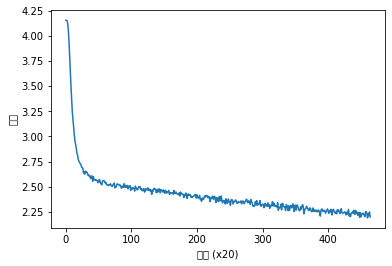

In [22]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
import numpy as np
from common import config
# config.GPU = True
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow2 import CBOW
from skip_gram2 import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 1

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
#model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


### 3) CBOW 모델 평가

In [23]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
from common.util import most_similar, analogy
import pickle

pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
  params = pickle.load(f)
  word_vecs = params['word_vecs']
  word_to_it = params['word_to_id']
  id_to_wrod = params['id_to_word']

querys = ['you', 'yers','car','toyota']
for query in querys:
  most_similar(query, word_to_id, id_to_word,word_vecs, top=5)


[query] you
 i: 0.98388671875
 we: 0.982421875
 'm: 0.97265625
 're: 0.94677734375
 anything: 0.9453125
yers(을)를 찾을 수 없습니다.

[query] car
 window: 0.96142578125
 road: 0.9599609375
 planet: 0.95703125
 score: 0.95361328125
 tree: 0.9521484375

[query] toyota
 alberta: 0.96484375
 kobe: 0.9609375
 bacteria: 0.95751953125
 oversubscribed: 0.9560546875
 tennessee: 0.955078125


In [24]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 share: 4.09375
 know: 4.07421875
 way: 4.0546875
 you: 4.0
 case: 3.921875

[analogy] take:took = go:?
 officer: 4.61328125
 chief: 4.40234375
 president: 4.296875
 cents: 4.26953125
 executive: 4.17578125

[analogy] car:cars = child:?
 addition: 4.23828125
 a.m: 4.0546875
 revenue: 4.0546875
 i: 3.861328125
 yield: 3.861328125

[analogy] good:better = bad:?
 <eos>: 3.494140625
 n't: 3.185546875
 quarter: 3.115234375
 market: 3.068359375
 do: 3.025390625


## 4. word2vec 남은 주제


### 1) word2vec을 이용한 애플리케이션의 예
> 자연어 처리 분야에서 단어의 분산 표현이 중요한 이유는 전이학습(transfer learning)에 있다. 전이학습은 한 분야에서 배운 지식을 다른 분야에 적용하는 기법이다.

### 2) 단어 벡터 평가 방법
- 일단 생략